In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from scipy.stats import norm

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
tf.set_random_seed(0)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from keras import backend as K
K.set_session(sess)

from keras.layers import Input, Dense, Lambda, BatchNormalization, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import metrics


from evaluation import *
np.random.seed(5)

Using TensorFlow backend.


In [2]:
import scipy.io
mat = scipy.io.loadmat('/home/olgako/data/datasets/thyroid.mat')

X_data = mat["X"]
X_data = StandardScaler().fit_transform(X_data)

labels = mat["y"]

In [3]:
X_data=MinMaxScaler().fit_transform(X_data)

In [4]:
from sklearn.model_selection import train_test_split
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, test_size=0.5, random_state = 5)

In [5]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [6]:
enc = OneHotEncoder()
enc.fit(labels)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [7]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [8]:
X_good.shape, X_train.shape, X_data.shape

((1840, 6), (1886, 6), (3772, 6))

In [9]:
original_dim = X_good.shape[1]
latent_dim = 4

batch_size = 512
epochs = 300
epsilon_std = 1.0

dropout_rate = 0.3
start_lr = 0.001

nh1 = 12
nh2 = 8

In [10]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

def apply_bn_and_dropout(x):
    return Dropout(dropout_rate)(BatchNormalization()(x))

In [11]:
models = {}

In [12]:
#encoder
inp = Input(shape=(original_dim,))
x = Dense(nh1, activation='relu')(inp)
x = apply_bn_and_dropout(x)
x = Dense(nh2, activation='relu')(x)
x = apply_bn_and_dropout(x)


z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)


# note that "output_shape" isn't necessary with the TensorFlow backend
l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


# decoder
z = Input(shape=(latent_dim, ))
x = Dense(nh2)(z)
x = LeakyReLU()(x)
x = apply_bn_and_dropout(x)
x = Dense(nh1)(x)
x = LeakyReLU()(x)
x = apply_bn_and_dropout(x)
decoded_mean = Dense(original_dim, activation='sigmoid')(x)


# instantiate models
models["encoder"]  = Model(inp, l, 'Encoder') 
models["z_meaner"] = Model(inp, z_mean, 'Enc_z_mean')
models["z_lvarer"] = Model(inp, z_log_var, 'Enc_z_log_var')
models["decoder"]  = Model(z, decoded_mean, name='Decoder')
models["vae"]      = Model(inp, models["decoder"](models["encoder"](inp)), name="VAE")

# # Compute VAE loss
def vae_loss(x, x_decoded_mean):
    # E[log P(X|z)]
    xent_loss = original_dim*metrics.binary_crossentropy(x, x_decoded_mean)
    # D_KL(Q(z|X) || P(z|X))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean((xent_loss + kl_loss))



vae = models["vae"]
vae.compile(optimizer=Adam(start_lr), loss=vae_loss)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
Encoder (Model)              (None, 4)                 340       
_________________________________________________________________
Decoder (Model)              (None, 6)                 306       
Total params: 646
Trainable params: 566
Non-trainable params: 80
_________________________________________________________________


In [13]:
# train the VAE
history = vae.fit(X_good, X_good,
          shuffle=True,
          epochs=epochs,
          validation_split = 0.1,
          batch_size=batch_size)


Train on 1656 samples, validate on 184 samples
Epoch 1/300
1656/1656 [==============================] - 0s - loss: 88.2199 - val_loss: 4.2189
Epoch 2/300
1656/1656 [==============================] - 0s - loss: 63.9915 - val_loss: 4.1973
Epoch 3/300
1656/1656 [==============================] - 0s - loss: 129.4517 - val_loss: 4.1813
Epoch 4/300
1656/1656 [==============================] - 0s - loss: 29.7087 - val_loss: 4.1616
Epoch 5/300
1656/1656 [==============================] - 0s - loss: 64.1513 - val_loss: 4.1573
Epoch 6/300
1656/1656 [==============================] - 0s - loss: 17.3207 - val_loss: 4.1332
Epoch 7/300
1656/1656 [==============================] - 0s - loss: 18.8896 - val_loss: 4.1330
Epoch 8/300
1656/1656 [==============================] - 0s - loss: 77.2144 - val_loss: 4.1181
Epoch 9/300
1656/1656 [==============================] - 0s - loss: 19.3177 - val_loss: 4.1065
Epoch 10/300
1656/1656 [==============================] - 0s - loss: 26.6120 - val_loss: 4.0907
E

1656/1656 [==============================] - 0s - loss: 7.8723 - val_loss: 3.5042
Epoch 87/300
1656/1656 [==============================] - 0s - loss: 6.8499 - val_loss: 3.4993
Epoch 88/300
1656/1656 [==============================] - 0s - loss: 6.4843 - val_loss: 3.4889
Epoch 89/300
1656/1656 [==============================] - 0s - loss: 7.1636 - val_loss: 3.4857
Epoch 90/300
1656/1656 [==============================] - 0s - loss: 6.3608 - val_loss: 3.4794
Epoch 91/300
1656/1656 [==============================] - 0s - loss: 7.9411 - val_loss: 3.4727
Epoch 92/300
1656/1656 [==============================] - 0s - loss: 6.6044 - val_loss: 3.4676
Epoch 93/300
1656/1656 [==============================] - 0s - loss: 7.3985 - val_loss: 3.4642
Epoch 94/300
1656/1656 [==============================] - 0s - loss: 6.5033 - val_loss: 3.4590
Epoch 95/300
1656/1656 [==============================] - 0s - loss: 7.9656 - val_loss: 3.4524
Epoch 96/300
1656/1656 [==============================] - 0s - 

1656/1656 [==============================] - 0s - loss: 5.0409 - val_loss: 3.3383
Epoch 172/300
1656/1656 [==============================] - 0s - loss: 5.1982 - val_loss: 3.3358
Epoch 173/300
1656/1656 [==============================] - 0s - loss: 5.1114 - val_loss: 3.3335
Epoch 174/300
1656/1656 [==============================] - 0s - loss: 5.0057 - val_loss: 3.3315
Epoch 175/300
1656/1656 [==============================] - 0s - loss: 4.9374 - val_loss: 3.3304
Epoch 176/300
1656/1656 [==============================] - 0s - loss: 4.9730 - val_loss: 3.3286
Epoch 177/300
1656/1656 [==============================] - 0s - loss: 4.9819 - val_loss: 3.3242
Epoch 178/300
1656/1656 [==============================] - 0s - loss: 6.2700 - val_loss: 3.3243
Epoch 179/300
1656/1656 [==============================] - 0s - loss: 5.0903 - val_loss: 3.3212
Epoch 180/300
1656/1656 [==============================] - 0s - loss: 5.0029 - val_loss: 3.3202
Epoch 181/300
1656/1656 [=============================

1656/1656 [==============================] - 0s - loss: 4.1674 - val_loss: 3.2252
Epoch 257/300
1656/1656 [==============================] - 0s - loss: 4.3252 - val_loss: 3.2248
Epoch 258/300
1656/1656 [==============================] - 0s - loss: 4.5262 - val_loss: 3.2237
Epoch 259/300
1656/1656 [==============================] - 0s - loss: 4.3155 - val_loss: 3.2238
Epoch 260/300
1656/1656 [==============================] - 0s - loss: 4.1996 - val_loss: 3.2211
Epoch 261/300
1656/1656 [==============================] - 0s - loss: 4.4498 - val_loss: 3.2210
Epoch 262/300
1656/1656 [==============================] - 0s - loss: 4.4061 - val_loss: 3.2208
Epoch 263/300
1656/1656 [==============================] - 0s - loss: 4.8101 - val_loss: 3.2194
Epoch 264/300
1656/1656 [==============================] - 0s - loss: 4.4441 - val_loss: 3.2188
Epoch 265/300
1656/1656 [==============================] - 0s - loss: 4.3411 - val_loss: 3.2169
Epoch 266/300
1656/1656 [=============================

In [14]:
def history_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

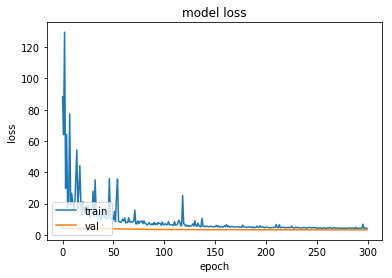

In [15]:
history_plot(history)

In [16]:
encoder= models["encoder"] 
generator = models["decoder"]

In [17]:
z_meaner = models["z_meaner"] 
z_lvarer = models["z_lvarer"] 

def vae_prob(x):
    x_decoded_mean=vae.predict(x)
    z_mean = z_meaner.predict(x)
    z_log_var = z_lvarer.predict(x)
    
    # E[log P(X|z)]
    xent_loss = original_dim*K.eval(metrics.binary_crossentropy(K.variable(x), K.variable(x_decoded_mean)))
    # D_KL(Q(z|X) || P(z|X))
    kl_loss = -0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=-1)

    return np.exp(-(xent_loss + kl_loss)/2./original_dim)

P@10 0.5
recalls_values [0.8, 0.9, 0.95, 0.99]
precision_values [0.071833648393194713, 0.066052227342549924, 0.061643835616438353, 0.036349574632637278]
average_precision_score 0.191383764295
roc_auc_score 0.854095079426


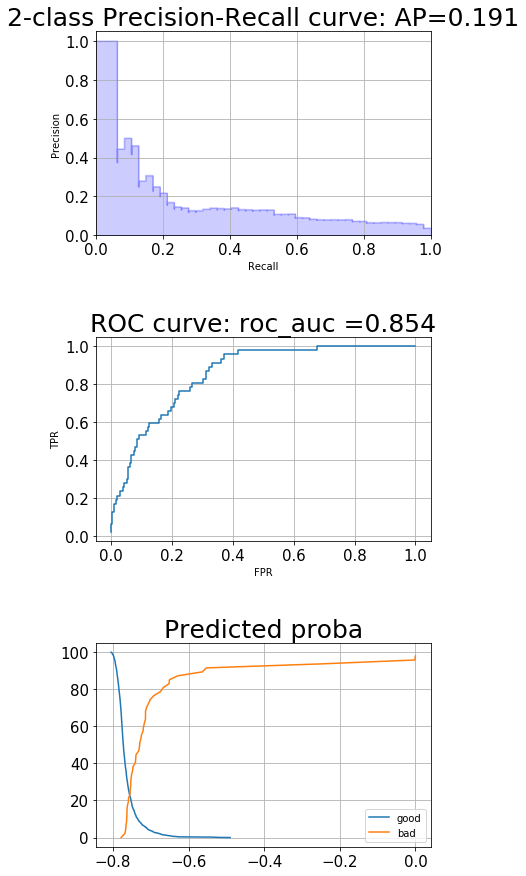

(array([ 0.03634957,  0.03560372,  0.03563129, ...,  1.        ,
         1.        ,  1.        ]),
 array([ 1.        ,  0.9787234 ,  0.9787234 , ...,  0.04255319,
         0.0212766 ,  0.        ]))

In [18]:
y_pred = -vae_prob(X_test)
perfomance(y_test, y_pred)

In [19]:
mean = np.zeros((latent_dim))
cov = np.eye(latent_dim)
z_samples = np.random.multivariate_normal(mean, cov, X_good.shape[0])
x_gen = generator.predict(z_samples)

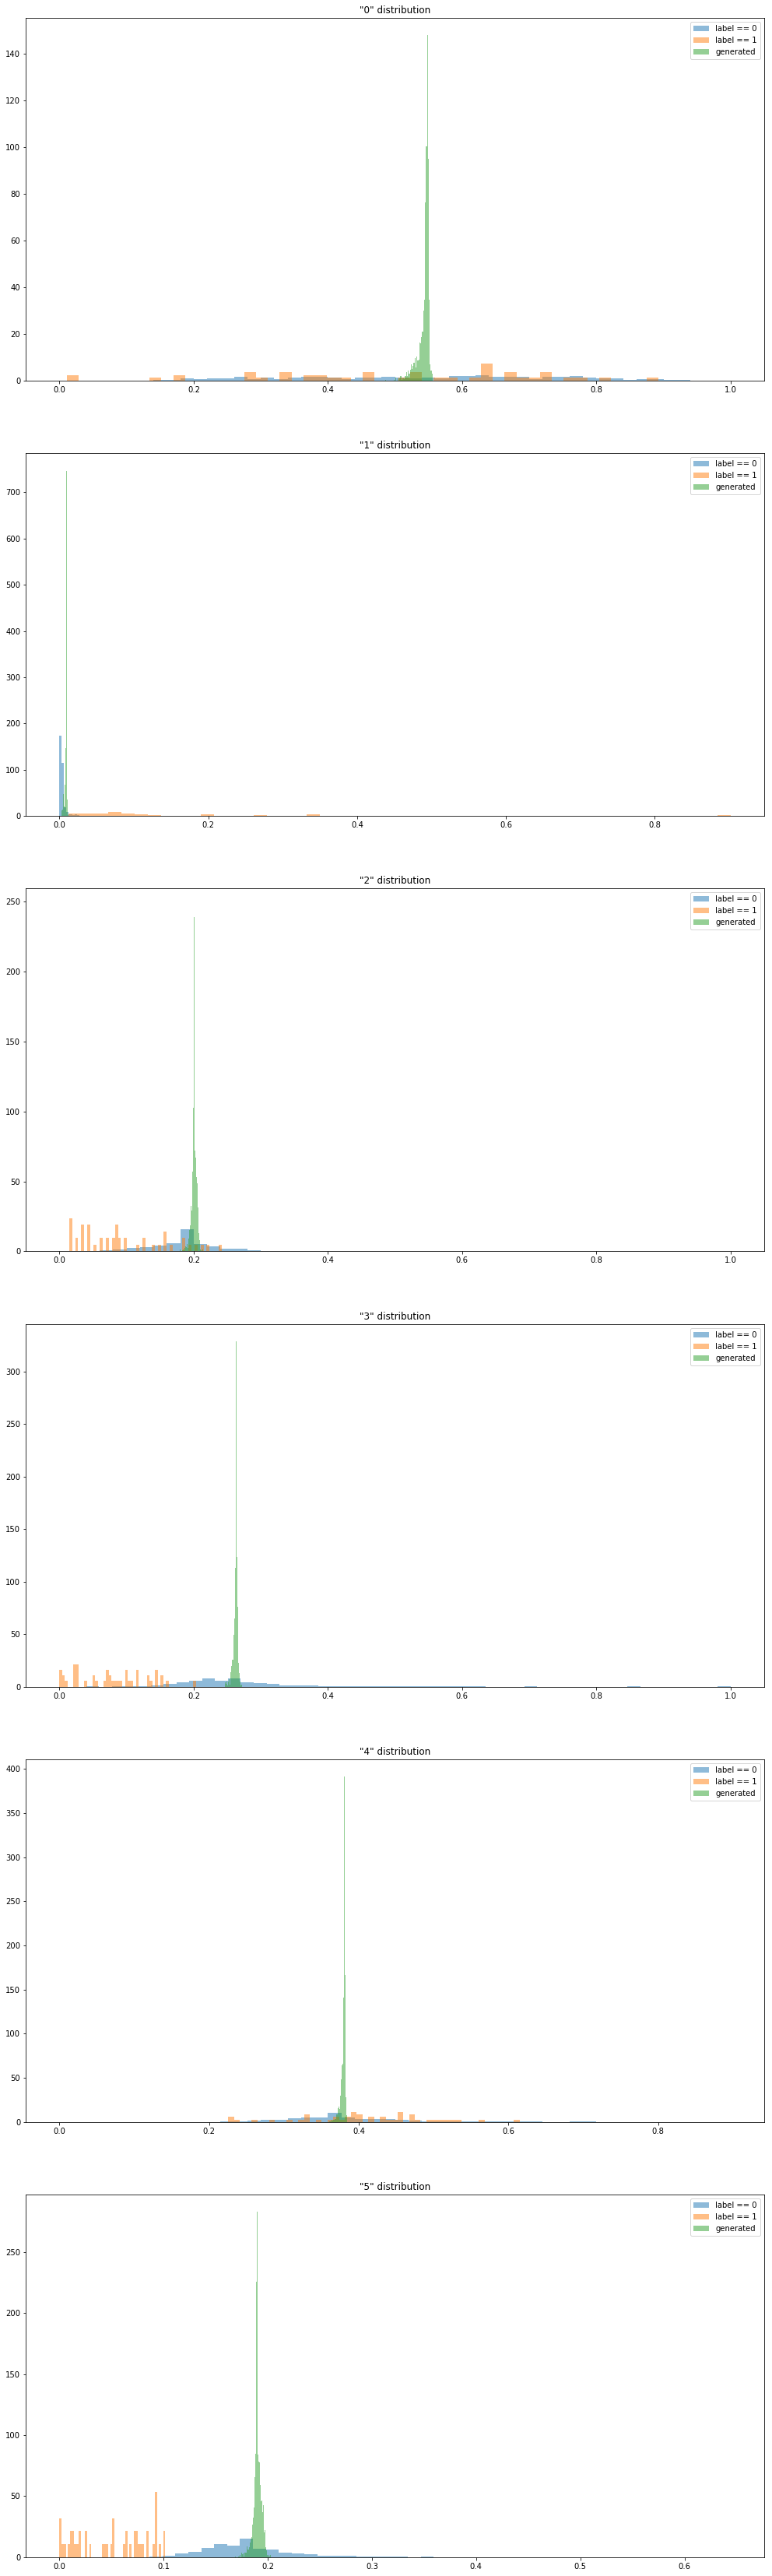

In [20]:
features_cnt = 6
plt.figure(figsize=(17,10*features_cnt))
for feature in range(features_cnt):
    plt.subplot(features_cnt,1,feature+1)
    plt.title('"%s" distribution' % feature)
    
    plt.hist(X_good[:,feature], label='label == 0', bins=50, alpha=0.5, normed=True)
    plt.hist(X_bad[:,feature], label='label == 1', bins=50, alpha=0.5, normed=True)
    plt.hist(x_gen[:,feature], label='generated', bins=50, alpha=0.5, normed=True)
    plt.legend()
plt.show()

In [21]:
gen_w = 1./vae_prob(x_gen)

In [22]:
gen_w.shape

(1840,)

In [23]:
gen_w = 1./vae_prob(x_gen)
weights = np.ones((X_good.shape[0],1))
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)
gen_w_normed.sum(), np.sum(weights)


(1840.0, 1840.0)

In [24]:
weights_mix = np.vstack((gen_w_normed.reshape(-1,1), weights.reshape(-1,1))).reshape(-1)

In [25]:
y1 = np.zeros((X_good.shape[0],1))
y2 = np.ones((x_gen.shape[0],1))

X_mix = np.vstack((x_gen, X_good)) 
y_mix = np.vstack((y2, y1))

In [26]:
def build_net():
    net = Sequential()
    net.add(Dense(64, input_shape=(6,), activation = 'relu'))
    #net.add(L.BatchNormalization())
    #net.add(L.Dense(32, activation='relu'))
    net.add(BatchNormalization())
    net.add(Dropout(0.2))
    net.add(Dense(1, activation='sigmoid'))

    adam = Adam(lr=0.001)
    net.compile(optimizer=adam, loss='binary_crossentropy')
    return net

In [27]:
clf_net = build_net()

Train on 3312 samples, validate on 368 samples
Epoch 1/20
0s - loss: 0.6812 - val_loss: 0.6958
Epoch 2/20
0s - loss: 0.5508 - val_loss: 0.7770
Epoch 3/20
0s - loss: 0.4807 - val_loss: 0.8046
Epoch 4/20
0s - loss: 0.4181 - val_loss: 0.8065
Epoch 5/20
0s - loss: 0.3798 - val_loss: 0.7927
Epoch 6/20
0s - loss: 0.3574 - val_loss: 0.7787
Epoch 7/20
0s - loss: 0.3403 - val_loss: 0.7692
Epoch 8/20
0s - loss: 0.3205 - val_loss: 0.7470
Epoch 9/20
0s - loss: 0.3042 - val_loss: 0.7266
Epoch 10/20
0s - loss: 0.2877 - val_loss: 0.6944
Epoch 11/20
0s - loss: 0.2733 - val_loss: 0.6691
Epoch 12/20
0s - loss: 0.2581 - val_loss: 0.6577
Epoch 13/20
0s - loss: 0.2449 - val_loss: 0.6287
Epoch 14/20
0s - loss: 0.2330 - val_loss: 0.5998
Epoch 15/20
0s - loss: 0.2238 - val_loss: 0.5752
Epoch 16/20
0s - loss: 0.2168 - val_loss: 0.5431
Epoch 17/20
0s - loss: 0.2058 - val_loss: 0.5153
Epoch 18/20
0s - loss: 0.1989 - val_loss: 0.4888
Epoch 19/20
0s - loss: 0.1882 - val_loss: 0.4742
Epoch 20/20
0s - loss: 0.1830 -

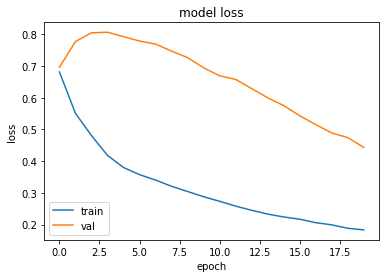

Train on 3312 samples, validate on 368 samples
Epoch 1/20
0s - loss: 0.1736 - val_loss: 0.4103
Epoch 2/20
0s - loss: 0.1682 - val_loss: 0.3935
Epoch 3/20
0s - loss: 0.1631 - val_loss: 0.3705
Epoch 4/20
0s - loss: 0.1563 - val_loss: 0.3400
Epoch 5/20
0s - loss: 0.1492 - val_loss: 0.3277
Epoch 6/20
0s - loss: 0.1450 - val_loss: 0.3178
Epoch 7/20
0s - loss: 0.1390 - val_loss: 0.2882
Epoch 8/20
0s - loss: 0.1333 - val_loss: 0.2681
Epoch 9/20
0s - loss: 0.1291 - val_loss: 0.2545
Epoch 10/20
0s - loss: 0.1253 - val_loss: 0.2234
Epoch 11/20
0s - loss: 0.1223 - val_loss: 0.2045
Epoch 12/20
0s - loss: 0.1258 - val_loss: 0.1978
Epoch 13/20
0s - loss: 0.1154 - val_loss: 0.1803
Epoch 14/20
0s - loss: 0.1141 - val_loss: 0.1800
Epoch 15/20
0s - loss: 0.1065 - val_loss: 0.1646
Epoch 16/20
0s - loss: 0.1084 - val_loss: 0.1539
Epoch 17/20
0s - loss: 0.1029 - val_loss: 0.1435
Epoch 18/20
0s - loss: 0.0997 - val_loss: 0.1296
Epoch 19/20
0s - loss: 0.0963 - val_loss: 0.1256
Epoch 20/20
0s - loss: 0.0902 -

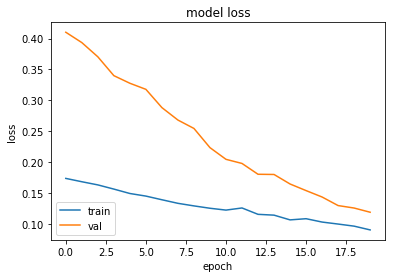

Train on 3312 samples, validate on 368 samples
Epoch 1/20
0s - loss: 0.0919 - val_loss: 0.1068
Epoch 2/20
0s - loss: 0.0912 - val_loss: 0.1005
Epoch 3/20
0s - loss: 0.0861 - val_loss: 0.0987
Epoch 4/20
0s - loss: 0.0860 - val_loss: 0.0887
Epoch 5/20
0s - loss: 0.0852 - val_loss: 0.0988
Epoch 6/20
0s - loss: 0.0810 - val_loss: 0.1107
Epoch 7/20
0s - loss: 0.0810 - val_loss: 0.1153
Epoch 8/20
0s - loss: 0.0743 - val_loss: 0.1001
Epoch 9/20
0s - loss: 0.0708 - val_loss: 0.0904
Epoch 10/20
0s - loss: 0.0735 - val_loss: 0.0865
Epoch 11/20
0s - loss: 0.0674 - val_loss: 0.0815
Epoch 12/20
0s - loss: 0.0708 - val_loss: 0.0832
Epoch 13/20
0s - loss: 0.0666 - val_loss: 0.0807
Epoch 14/20
0s - loss: 0.0699 - val_loss: 0.0823
Epoch 15/20
0s - loss: 0.0634 - val_loss: 0.0874
Epoch 16/20
0s - loss: 0.0608 - val_loss: 0.0857
Epoch 17/20
0s - loss: 0.0629 - val_loss: 0.0807
Epoch 18/20
0s - loss: 0.0574 - val_loss: 0.0678
Epoch 19/20
0s - loss: 0.0609 - val_loss: 0.0689
Epoch 20/20
0s - loss: 0.0591 -

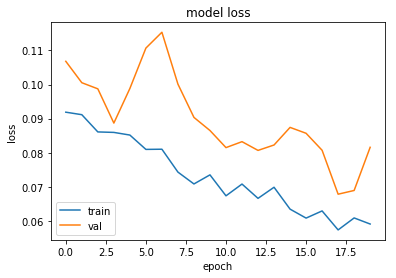

Train on 3312 samples, validate on 368 samples
Epoch 1/20
0s - loss: 0.0545 - val_loss: 0.1019
Epoch 2/20
0s - loss: 0.0546 - val_loss: 0.0843
Epoch 3/20
0s - loss: 0.0536 - val_loss: 0.0710
Epoch 4/20
0s - loss: 0.0505 - val_loss: 0.0743
Epoch 5/20
0s - loss: 0.0505 - val_loss: 0.0726
Epoch 6/20
0s - loss: 0.0514 - val_loss: 0.0836
Epoch 7/20
0s - loss: 0.0497 - val_loss: 0.0854
Epoch 8/20
0s - loss: 0.0467 - val_loss: 0.0822
Epoch 9/20
0s - loss: 0.0436 - val_loss: 0.0923
Epoch 10/20
0s - loss: 0.0473 - val_loss: 0.0972
Epoch 11/20
0s - loss: 0.0445 - val_loss: 0.0796
Epoch 12/20
0s - loss: 0.0456 - val_loss: 0.0745
Epoch 13/20
0s - loss: 0.0432 - val_loss: 0.0839
Epoch 14/20
0s - loss: 0.0444 - val_loss: 0.0795
Epoch 15/20
0s - loss: 0.0424 - val_loss: 0.0888
Epoch 16/20
0s - loss: 0.0406 - val_loss: 0.0717
Epoch 17/20
0s - loss: 0.0412 - val_loss: 0.0725
Epoch 18/20
0s - loss: 0.0420 - val_loss: 0.0796
Epoch 19/20
0s - loss: 0.0446 - val_loss: 0.0660
Epoch 20/20
0s - loss: 0.0362 -

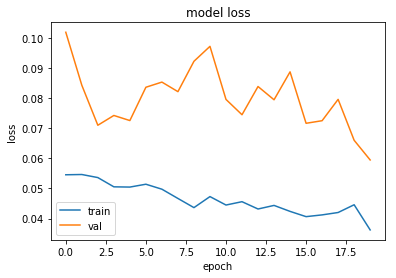

Train on 3312 samples, validate on 368 samples
Epoch 1/20
0s - loss: 0.0374 - val_loss: 0.0628
Epoch 2/20
0s - loss: 0.0374 - val_loss: 0.0575
Epoch 3/20
0s - loss: 0.0353 - val_loss: 0.0677
Epoch 4/20
0s - loss: 0.0338 - val_loss: 0.0639
Epoch 5/20
0s - loss: 0.0330 - val_loss: 0.0695
Epoch 6/20
0s - loss: 0.0326 - val_loss: 0.0606
Epoch 7/20
0s - loss: 0.0329 - val_loss: 0.0570
Epoch 8/20
0s - loss: 0.0319 - val_loss: 0.0546
Epoch 9/20
0s - loss: 0.0316 - val_loss: 0.0612
Epoch 10/20
0s - loss: 0.0340 - val_loss: 0.0655
Epoch 11/20
0s - loss: 0.0313 - val_loss: 0.0578
Epoch 12/20
0s - loss: 0.0301 - val_loss: 0.0518
Epoch 13/20
0s - loss: 0.0302 - val_loss: 0.0667
Epoch 14/20
0s - loss: 0.0318 - val_loss: 0.0504
Epoch 15/20
0s - loss: 0.0302 - val_loss: 0.0625
Epoch 16/20
0s - loss: 0.0294 - val_loss: 0.0541
Epoch 17/20
0s - loss: 0.0296 - val_loss: 0.0558
Epoch 18/20
0s - loss: 0.0292 - val_loss: 0.0578
Epoch 19/20
0s - loss: 0.0281 - val_loss: 0.0640
Epoch 20/20
0s - loss: 0.0279 -

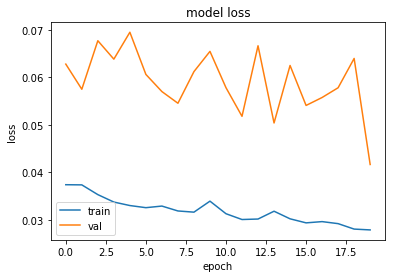

Train on 3312 samples, validate on 368 samples
Epoch 1/20
0s - loss: 0.0307 - val_loss: 0.0601
Epoch 2/20
0s - loss: 0.0309 - val_loss: 0.0565
Epoch 3/20
0s - loss: 0.0294 - val_loss: 0.0819
Epoch 4/20
0s - loss: 0.0282 - val_loss: 0.0715
Epoch 5/20
0s - loss: 0.0263 - val_loss: 0.0671
Epoch 6/20
0s - loss: 0.0291 - val_loss: 0.0673
Epoch 7/20
0s - loss: 0.0281 - val_loss: 0.0667
Epoch 8/20
0s - loss: 0.0258 - val_loss: 0.0652
Epoch 9/20
0s - loss: 0.0240 - val_loss: 0.0639
Epoch 10/20
0s - loss: 0.0260 - val_loss: 0.0446
Epoch 11/20
0s - loss: 0.0276 - val_loss: 0.0473
Epoch 12/20
0s - loss: 0.0236 - val_loss: 0.0375
Epoch 13/20
0s - loss: 0.0272 - val_loss: 0.0358
Epoch 14/20
0s - loss: 0.0250 - val_loss: 0.0397
Epoch 15/20
0s - loss: 0.0264 - val_loss: 0.0456
Epoch 16/20
0s - loss: 0.0225 - val_loss: 0.0383
Epoch 17/20
0s - loss: 0.0244 - val_loss: 0.0465
Epoch 18/20
0s - loss: 0.0254 - val_loss: 0.0557
Epoch 19/20
0s - loss: 0.0239 - val_loss: 0.0454
Epoch 20/20
0s - loss: 0.0222 -

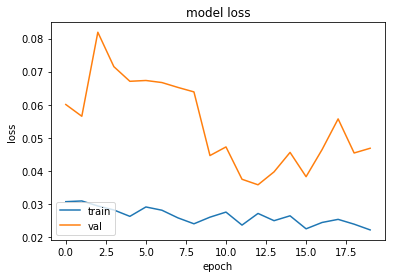

Train on 3312 samples, validate on 368 samples
Epoch 1/20
0s - loss: 0.0221 - val_loss: 0.0437
Epoch 2/20
0s - loss: 0.0291 - val_loss: 0.0416
Epoch 3/20
0s - loss: 0.0242 - val_loss: 0.0514
Epoch 4/20
0s - loss: 0.0237 - val_loss: 0.0444
Epoch 5/20
0s - loss: 0.0230 - val_loss: 0.0399
Epoch 6/20
0s - loss: 0.0245 - val_loss: 0.0371
Epoch 7/20
0s - loss: 0.0232 - val_loss: 0.0587
Epoch 8/20
0s - loss: 0.0242 - val_loss: 0.0383
Epoch 9/20
0s - loss: 0.0257 - val_loss: 0.0364
Epoch 10/20
0s - loss: 0.0226 - val_loss: 0.0599
Epoch 11/20
0s - loss: 0.0231 - val_loss: 0.0339
Epoch 12/20
0s - loss: 0.0227 - val_loss: 0.0570
Epoch 13/20
0s - loss: 0.0216 - val_loss: 0.0554
Epoch 14/20
0s - loss: 0.0203 - val_loss: 0.0535
Epoch 15/20
0s - loss: 0.0205 - val_loss: 0.0580
Epoch 16/20
0s - loss: 0.0210 - val_loss: 0.0464
Epoch 17/20
0s - loss: 0.0209 - val_loss: 0.0483
Epoch 18/20
0s - loss: 0.0235 - val_loss: 0.0410
Epoch 19/20
0s - loss: 0.0223 - val_loss: 0.0590
Epoch 20/20
0s - loss: 0.0215 -

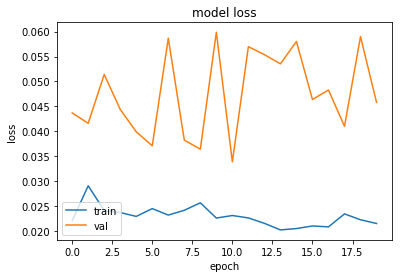

Train on 3312 samples, validate on 368 samples
Epoch 1/20
0s - loss: 0.0226 - val_loss: 0.0551
Epoch 2/20
0s - loss: 0.0202 - val_loss: 0.0311
Epoch 3/20
0s - loss: 0.0196 - val_loss: 0.0387
Epoch 4/20
0s - loss: 0.0196 - val_loss: 0.0296
Epoch 5/20
0s - loss: 0.0210 - val_loss: 0.0409
Epoch 6/20
0s - loss: 0.0200 - val_loss: 0.0495
Epoch 7/20
0s - loss: 0.0197 - val_loss: 0.0395
Epoch 8/20
0s - loss: 0.0214 - val_loss: 0.0533
Epoch 9/20
0s - loss: 0.0198 - val_loss: 0.0448
Epoch 10/20
0s - loss: 0.0180 - val_loss: 0.0289
Epoch 11/20
0s - loss: 0.0201 - val_loss: 0.0429
Epoch 12/20
0s - loss: 0.0189 - val_loss: 0.0336
Epoch 13/20
0s - loss: 0.0185 - val_loss: 0.0414
Epoch 14/20
0s - loss: 0.0169 - val_loss: 0.0332
Epoch 15/20
0s - loss: 0.0185 - val_loss: 0.0273
Epoch 16/20
0s - loss: 0.0198 - val_loss: 0.0467
Epoch 17/20
0s - loss: 0.0188 - val_loss: 0.0360
Epoch 18/20
0s - loss: 0.0210 - val_loss: 0.0369
Epoch 19/20
0s - loss: 0.0191 - val_loss: 0.0539
Epoch 20/20
0s - loss: 0.0196 -

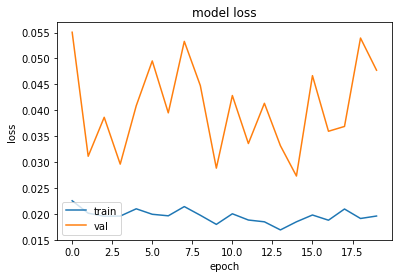

Train on 3312 samples, validate on 368 samples
Epoch 1/20
0s - loss: 0.0216 - val_loss: 0.0543
Epoch 2/20
0s - loss: 0.0191 - val_loss: 0.0296
Epoch 3/20
0s - loss: 0.0191 - val_loss: 0.0593
Epoch 4/20
0s - loss: 0.0198 - val_loss: 0.0406
Epoch 5/20
0s - loss: 0.0201 - val_loss: 0.0301
Epoch 6/20
0s - loss: 0.0180 - val_loss: 0.0293
Epoch 7/20
0s - loss: 0.0186 - val_loss: 0.0446
Epoch 8/20
0s - loss: 0.0195 - val_loss: 0.0336
Epoch 9/20
0s - loss: 0.0211 - val_loss: 0.0472
Epoch 10/20
0s - loss: 0.0205 - val_loss: 0.0370
Epoch 11/20
0s - loss: 0.0187 - val_loss: 0.0497
Epoch 12/20
0s - loss: 0.0198 - val_loss: 0.0327
Epoch 13/20
0s - loss: 0.0210 - val_loss: 0.0252
Epoch 14/20
0s - loss: 0.0189 - val_loss: 0.0201
Epoch 15/20
0s - loss: 0.0183 - val_loss: 0.0255
Epoch 16/20
0s - loss: 0.0219 - val_loss: 0.0317
Epoch 17/20
0s - loss: 0.0180 - val_loss: 0.0222
Epoch 18/20
0s - loss: 0.0183 - val_loss: 0.0510
Epoch 19/20
0s - loss: 0.0208 - val_loss: 0.0354
Epoch 20/20
0s - loss: 0.0189 -

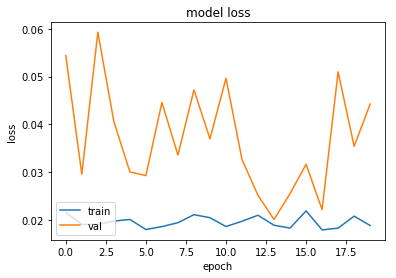

Train on 3312 samples, validate on 368 samples
Epoch 1/20
0s - loss: 0.0200 - val_loss: 0.0371
Epoch 2/20
0s - loss: 0.0187 - val_loss: 0.0353
Epoch 3/20
0s - loss: 0.0178 - val_loss: 0.0458
Epoch 4/20
0s - loss: 0.0159 - val_loss: 0.0388
Epoch 5/20
0s - loss: 0.0179 - val_loss: 0.0473
Epoch 6/20
0s - loss: 0.0173 - val_loss: 0.0395
Epoch 7/20
0s - loss: 0.0177 - val_loss: 0.0248
Epoch 8/20
0s - loss: 0.0161 - val_loss: 0.0204
Epoch 9/20
0s - loss: 0.0192 - val_loss: 0.0506
Epoch 10/20
0s - loss: 0.0199 - val_loss: 0.0161
Epoch 11/20
0s - loss: 0.0186 - val_loss: 0.0436
Epoch 12/20
0s - loss: 0.0192 - val_loss: 0.0390
Epoch 13/20
0s - loss: 0.0184 - val_loss: 0.0165
Epoch 14/20
0s - loss: 0.0194 - val_loss: 0.0353
Epoch 15/20
0s - loss: 0.0182 - val_loss: 0.0313
Epoch 16/20
0s - loss: 0.0156 - val_loss: 0.0316
Epoch 17/20
0s - loss: 0.0157 - val_loss: 0.0317
Epoch 18/20
0s - loss: 0.0178 - val_loss: 0.0159
Epoch 19/20
0s - loss: 0.0186 - val_loss: 0.0421
Epoch 20/20
0s - loss: 0.0172 -

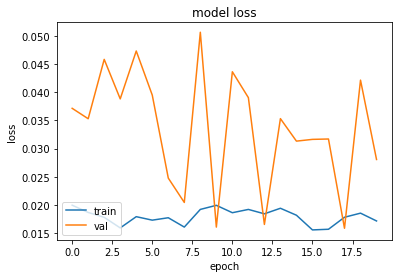

In [28]:
n_generations = 10

for generation in range(n_generations):
    z_samples = np.random.multivariate_normal(mean, cov, X_good.shape[0])
    x_gen = generator.predict(z_samples)
    
    gen_w = 1./vae_prob(x_gen)
    gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)
    
    weights_mix = np.vstack((gen_w_normed.reshape(-1,1), weights.reshape(-1,1))).reshape(-1)
    X_mix = np.vstack((x_gen, X_good))
    
    history = clf_net.fit(X_mix, y_mix, 
                          batch_size=256, epochs=20, validation_split = 0.1, verbose=2, shuffle=True, 
                          sample_weight=weights_mix)
    history_plot(history)

1408/1886 [=====================>........] - ETA: 0sP@10 0.0
recalls_values [0.8, 0.9, 0.95, 0.99]
precision_values [0.025160599571734475, 0.025160599571734475, 0.025160599571734475, 0.025160599571734475]
average_precision_score 0.0146638262036
roc_auc_score 0.221373780848


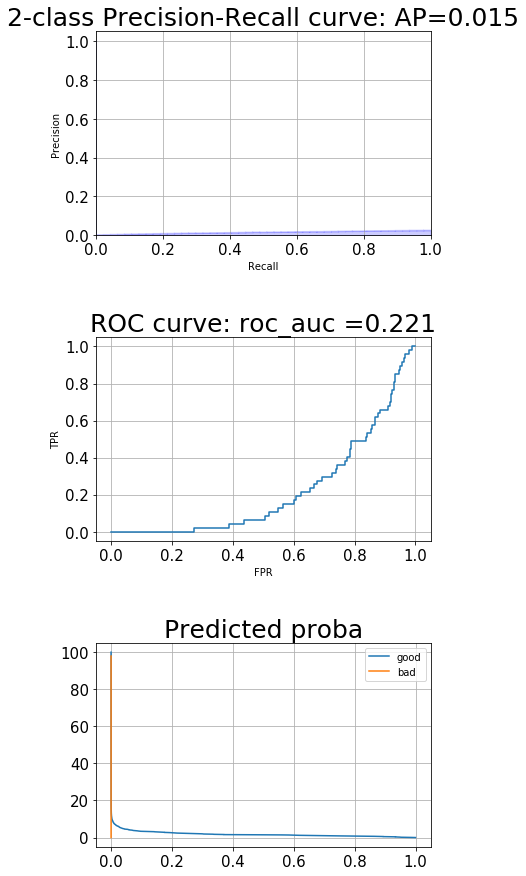

(array([ 0.0251606 ,  0.02463846,  0.02465166, ...,  0.        ,
         0.        ,  1.        ]),
 array([ 1.       ,  0.9787234,  0.9787234, ...,  0.       ,  0.       ,  0.       ]))

In [29]:
y_pred = clf_net.predict(X_test, verbose=1)
perfomance(y_test, y_pred.reshape(-1))

1760/1840 [===========================>..] - ETA: 0s

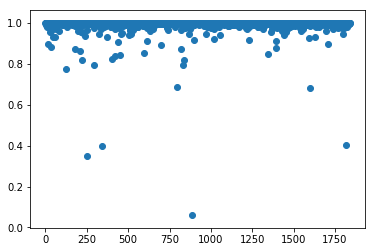

In [30]:
plt.scatter(np.arange(len(x_gen)),clf_net.predict(x_gen, verbose=1))
plt.show()